In [178]:
import os
import torch
import math
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import json
import cv2
import re
import random
import torchvision.transforms as transforms
from torchvision.io import read_image

import matplotlib.pyplot as plt
import torchvision.transforms as T

import nbimporter
from siamese import get_siam_net
from simclr import get_simclr_net


class PanopticDataset(Dataset):
    def __init__(self, transform):

        self.data_path = "../../dataset/Panoptic/ProcessedPanopticDataset/"
#         self.data_path = '/media/mmlab/Volume/Panoptic/ProcessedPanopticDataset/'
        self.training_dir = []
        
        self.transform = transform

        paths = []

        motion_seq = os.listdir(self.data_path)
        no_dir = ['scripts','python','matlab','.git','glViewer.py','README.md','matlab',
                'README_kinoptic.md']
    
        for dir in motion_seq:
            if dir not in no_dir:
                if 'haggling' in dir:
                    continue
                elif dir == '171204_pose2' or dir =='171204_pose5' or dir =='171026_cello3':
                    if os.path.exists(os.path.join(self.data_path,dir,'hdJoints')):
                        data_path = os.path.join(self.data_path,dir,'hdJoints')
                        for lists in (os.listdir(data_path)):
                            paths.append(os.path.join(data_path,lists.split('.json')[0]))
                elif 'ian' in dir:
                    continue
                else:
                    if os.path.exists(os.path.join(self.data_path,dir,'hdJoints')):
                        data_path = os.path.join(self.data_path,dir,'hdJoints')
                        for lists in (os.listdir(data_path)):
                            paths.append(os.path.join(data_path,lists.split('.json')[0]))

        self.data = {'paths': paths}

    def __len__(self):
        return len(self.data['paths'])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = dict()

        path_split = self.data['paths'][idx].split('/hdJoints')
        image_path = path_split[0] + '/hdImages' + path_split[-1] + '.jpg'
        
        image = cv2.imread(image_path)
        image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        
        sample['image'] = image
        
        joints_path = self.data['paths'][idx]+'.json'
        
        with open(joints_path) as dfile:
            bframe = json.load(dfile)
            
        poses_2d = torch.tensor(np.array(bframe['poses_2d'])) 
        scale = 128 / 224
        poses_2d = poses_2d * scale
        
        sample['poses_2d'] =  torch.round(poses_2d)
        
        return sample

In [120]:
# uncomment this if you get an error
# !pip3 install pytorch-lightning==1.2.2

### On top of a base encoder, a simple linear layer is attached that predicts 19 pairs of joints. The base encoder can be either SimCLR or Siamese models. I remove the projection head (or projection and prediction in case of Siamese) and use only the output of the base encoder, which is the output of AvrPool layer.

In [179]:
class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.layers = nn.Sequential(nn.Linear(2048, 19 * 2))
 
    def forward(self, x):
        z = self.layers(x)
        return z

In [133]:
def get_linear_evaluation_model(path, base):
    
    base.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    
    base.fc = Linear()
    
    return base

### I freeze all the layers of the base encoder and use Stochastic gradient descent to train only the linear layer.

In [134]:
from torch.optim import SGD


def get_optimizer(net, learning_rate, weight_decay, momentum):
    final_layer_weights = []
    rest_of_the_net_weights = []

    for name, param in net.named_parameters():
        if name.startswith('fc'):
            final_layer_weights.append(param)
        else:
            param.requires_grad = False
  
    optimizer = SGD([
        {'params': final_layer_weights, 'lr': learning_rate}
    ], weight_decay=weight_decay, momentum=momentum)

    
    return optimizer

### The images are resized into (128, 128) since the models were trained using this size. The dataset is split into 60%/20%/20% for training, validation and testing.

In [173]:
generator = torch.Generator().manual_seed(42)

def get_data(batch_size):
    
    transforms = T.Compose(
        [
            T.ToTensor(),
            T.Resize(size=(128, 128)),
        ]
    )

    data = PanopticDataset(transforms)
    
    num_samples = len(data)
    
    training_samples = int(num_samples * 0.6 + 1)
    val_samples = int(num_samples * 0.2 + 1)
    test_samples = num_samples - training_samples - val_samples
    
    training_data, val_data, test_data = torch.utils.data.random_split(
        data, [training_samples, val_samples, test_samples], generator=generator
    )

    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

    return training_data, val_data, test_data, train_loader, val_loader, test_loader

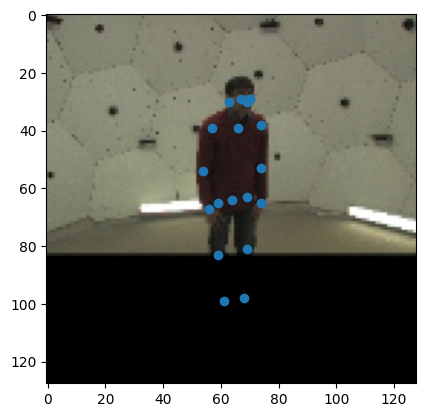

In [180]:
training_data, _, _, _, _, _ = get_data(200)

image = training_data[9]['image']
coords = training_data[9]['poses_2d'].reshape((-1,2))

imgplot = plt.imshow(image.permute(1, 2, 0))

plt.scatter(coords[:, 0], coords[:, 1])
plt.show()

### The loss function that is used for training is L1 loss. As an accuracy metrics I report average euclidean distance between true and predicted joints. The model is also trained for 20 epochs.

In [152]:
from tqdm import tqdm


def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    net.train()

    for batch_idx, batch in enumerate(tqdm(data_loader)):

        images = batch['image']
        poses = batch['poses_2d']
        
        images = images.to(device)
        poses = poses.to(device)
             
        output = net(images)

        loss = cost_function(output, poses)
        cumulative_loss += loss.item()

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        samples += images.shape[0]
        
        cumulative_accuracy += torch.cdist(output, poses, 2).mean()

    return cumulative_loss / samples, cumulative_accuracy / samples


def test_step(net, data_loader, cost_function, device='cuda'):
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    net.eval() 

    with torch.no_grad():

        for batch_idx, batch in enumerate(tqdm(data_loader)):
            images = batch['image']
            poses = batch['poses_2d']
        
            images = images.to(device)
            poses = poses.to(device)
            
            output = net(images)

            loss = cost_function(output, poses)
            cumulative_loss += loss.item()
            
            samples += images.shape[0]
            cumulative_accuracy += torch.cdist(output, poses, 2).mean()

    return cumulative_loss / samples, cumulative_accuracy / samples

In [209]:
def main(path, base, batch_size=128, device='cuda', learning_rate=0.05, weight_decay=0.000001, momentum=0.9, epochs=20):
    _, _, _, train_loader, val_loader, test_loader = get_data(batch_size)
    
    net = get_linear_evaluation_model(path, base).to(device)
    
    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
    
    cost_function = nn.L1Loss(reduction='mean')
    
    for e in range(epochs):
    
        train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function, device)
        val_loss, val_accuracy = test_step(net, val_loader, cost_function, device)

        print('Epoch: {:d}'.format(e+1))
        print('\tTraining loss {:.5f}, Training Acc {:.4f}'.format(train_loss, train_accuracy))
        print('\tValidation loss {:.5f}, Validation Acc {:.2f}'.format(val_loss, val_accuracy))
        print('-----------------------------------------------------')

        torch.save(net.state_dict(), 'sim_linear.pt')

    print('After training:')
    train_loss, train_accuracy = test_step(net, train_loader, cost_function, device)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function, device)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function, device)
    
    print('\tTraining loss {:.5f}, Training Acc {:.4f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation Acc {:.4f}'.format(val_loss, val_accuracy))
    print('\tTest loss {:.5f}, Test Acc {:.4f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')


In [219]:
simclr_path = '../trained_models/ver1.pt'
# siam_path = '../trained_models/siam.pt'

# siam = get_siam_net()
simclr = get_simclr_net()

main(simclr_path, simclr)

In [205]:
def print_one_example(model, ind):
    """Function to plot true and predicted joints"""
    image = test_data[ind]['image']
    true_coords = test_data[ind]['poses_2d'].reshape((-1,2))
    
    image_input = image.unsqueeze(0)
    pred_coords = model(image_input)[0].reshape((-1,2)).detach().numpy()
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figheight(10)
    f.set_figwidth(10)
    
    ax1.imshow(image.permute(1, 2, 0))
    ax1.scatter(true_coords[:, 0], true_coords[:, 1], marker='.')
    ax1.set_title("True joints")
    
    ax2.imshow(image.permute(1, 2, 0))
    ax2.scatter(pred_coords[:, 0], pred_coords[:, 1], marker='.')
    ax2.set_title("Predicted joints")

    plt.show()

# 2D pose estimation using SimCLR model

The average euclidean distance between true and predicted joints after training is:
- Training set: 0.4431
- Validation set: 0.4442
- Test set: 0.4444

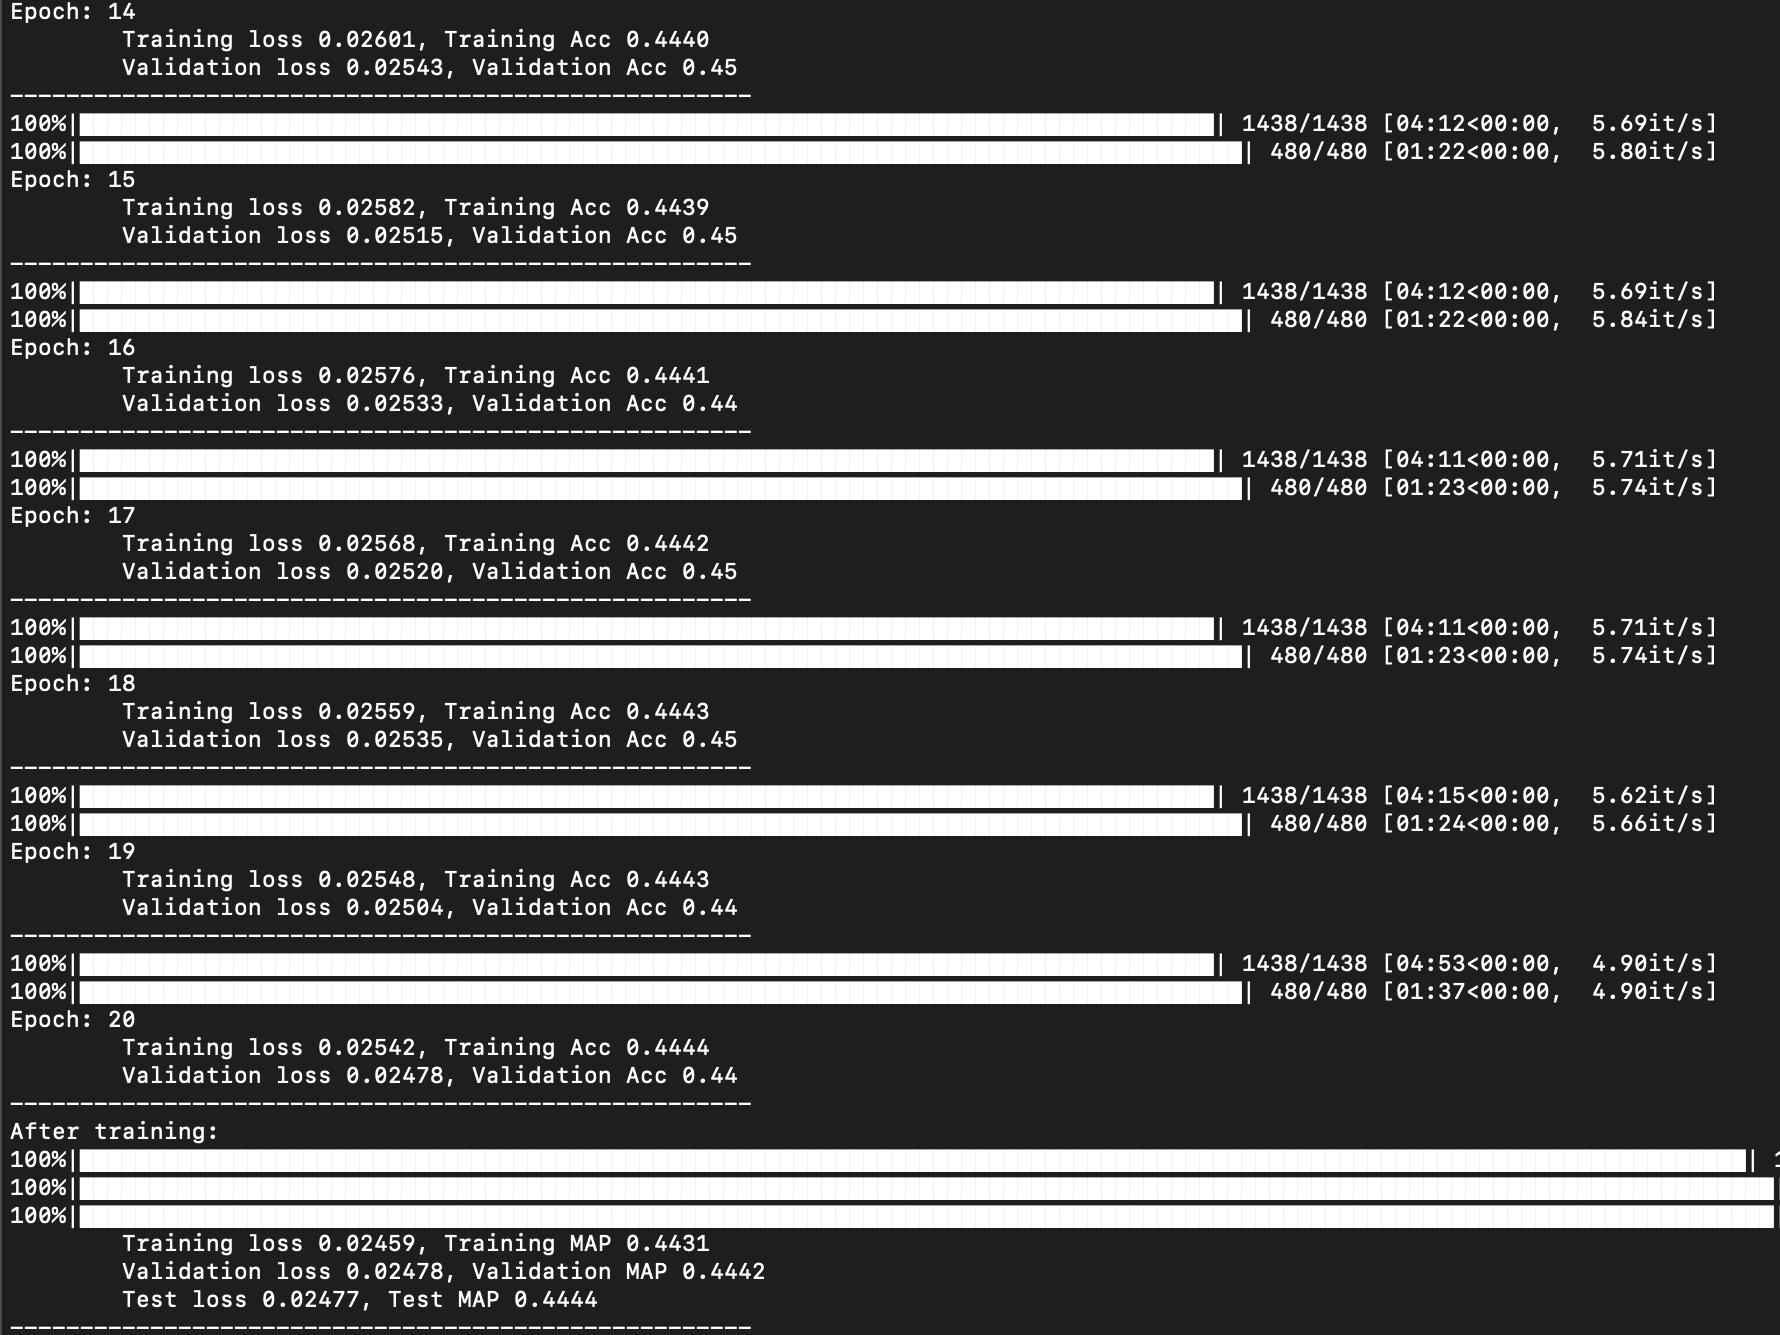

In [174]:
_, _, test_data, _, _, _ = get_data(200)

In [221]:
path = '../trained_models/sim_linear.pt'

simclr_model = get_linear_evaluation_model(simclr_path, simclr)
simclr_model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

simclr_model.eval()

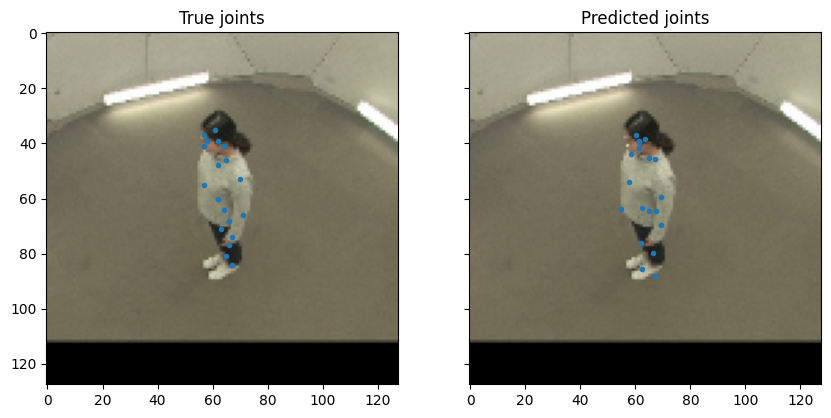

In [214]:
print_one_example(simclr_model, 0)

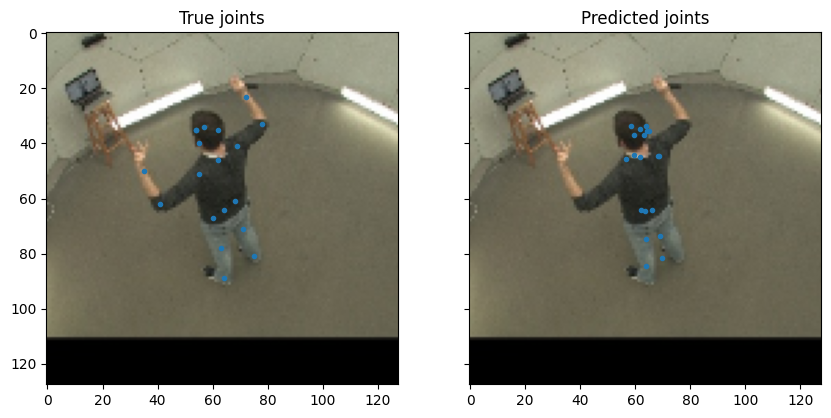

In [215]:
print_one_example(simclr_model, 145)

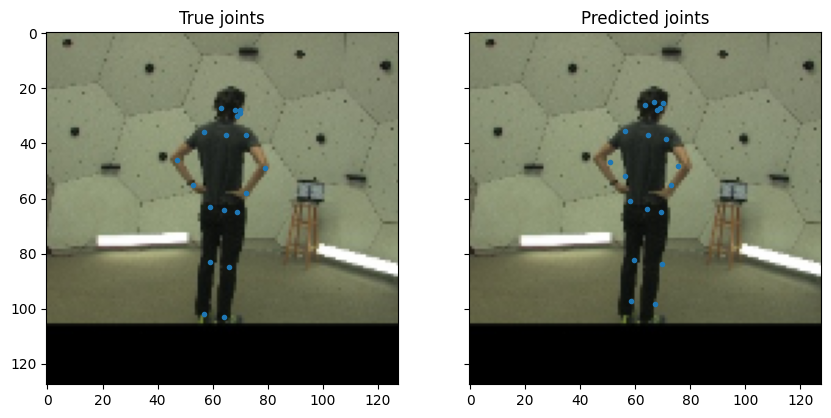

In [216]:
print_one_example(simclr_model, 40)

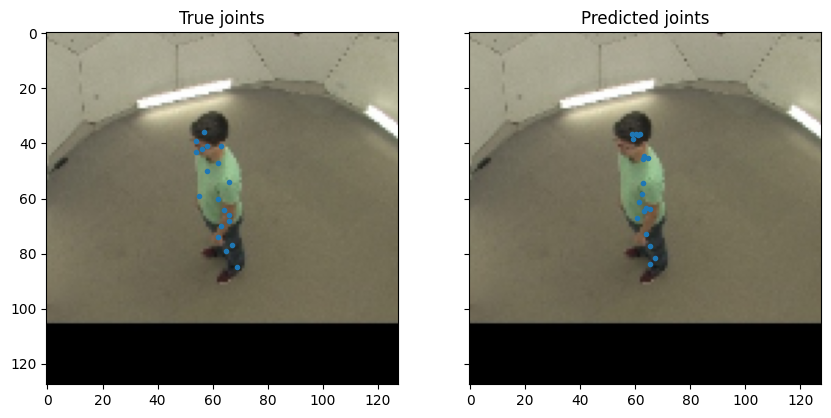

In [217]:
print_one_example(simclr_model, 66)